<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 20px; height: 55px">

# Capstone Project: Vehicle Insurance Fraud Detection

## Part II: Modelling

Based on the dataset, we can tell that it is an imbalance class dataset. Imbalanced fraud datasets are common in fraud detection where fraudulent instances are often rare and heavily outnumbered by legitimate transaction. To handle imbalanced datasets, there are several classification techniques that work well. 

We will be exploring the different types of classifications to determine the best model to deplore it into production. The criteria metrics that we will be looking in the model wil be based on `precision` and `ROC_AUC` curve. 

By focusing on `precision`, we can ensure that our model is correctly identifying as many fraud cases as possible while minimizing the number of false positives. `ROC_AUC`, on the other hand, helps to assess the model's ability to distinguish between fraud and non-fraud cases across different thresholds, providing a more complete picture of the model's performance.

### Import Libraries / Datasets

In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns
import scipy.stats as ss
from scipy.stats import f_oneway, norm
from collections import Counter
import math
from itertools import product


import warnings
warnings.filterwarnings('ignore')

from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, cross_val_score, RepeatedStratifiedKFold, GridSearchCV
from sklearn.metrics import classification_report, f1_score, roc_auc_score, confusion_matrix, accuracy_score
from sklearn.metrics import roc_curve, roc_auc_score, ConfusionMatrixDisplay, recall_score, precision_score

from category_encoders.ordinal import OrdinalEncoder
from category_encoders.one_hot import OneHotEncoder

from xgboost import XGBClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from imblearn.ensemble import BalancedRandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression


In [2]:
df = pd.read_csv('./datasets/cleaned_fraud_oracle.csv')

### Preprocessing

We will be dropping the following features

- `PolicyType` It is a combination of `Base Policy` and `Vehicle Category`
- `Policy Number` Running number of the individual index
- `Rep Number` Number of the rep which is from 1 to 16. 


In [3]:
df = df.drop(columns = ['PolicyType','PolicyNumber','RepNumber'])

### Ordinal Encoding

In [4]:
#def columns to be in ordinal encoding
ordinal_cols = [
    {'col':'Month','mapping':{'Jan':1,'Feb':2,'Mar':3,'Apr':4,'May':5,'Jun':6,'Jul':7,'Aug':8,'Sep':9,'Oct':10,'Nov':11,'Dec':12}},
    {'col':'DayOfWeek','mapping':{'Monday':1,'Tuesday':2,'Wednesday':3,'Thursday':4,'Friday':5,'Saturday':6,'Sunday':7}},
    {'col':'DayOfWeekClaimed','mapping':{'Monday':1,'Tuesday':2,'Wednesday':3,'Thursday':4,'Friday':5,'Saturday':6,'Sunday':7}},
    {'col':'MonthClaimed','mapping':{'Jan':1,'Feb':2,'Mar':3,'Apr':4,'May':5,'Jun':6,'Jul':7,'Aug':8,'Sep':9,'Oct':10,'Nov':11,'Dec':12}},
    {'col':'PastNumberOfClaims','mapping':{'none':0 ,'1':1,'2 to 4':2,'more than 4':3 }},
    {'col':'NumberOfSuppliments','mapping':{'none':0,'1 to 2':1,'3 to 5':2,'more than 5':3}}, 
    {'col':'VehiclePrice','mapping':{'less than 20000':0,'20000 to 29000':1,'30000 to 39000':2,
                                     '40000 to 59000':3,'60000 to 69000':4,'more than 69000':5}},
    {'col':'AgeOfVehicle','mapping':{'3 years':3,'6 years':6,'7 years':7,'more than 7':8,'5 years':5,'new':0,'4 years':4,'2 years':2}},
    {'col':'Days_Policy_Accident','mapping':{'more than 30':4,'15 to 30':3,'none':0,'1 to 7':1,'8 to 15':2}},
    {'col':'Days_Policy_Claim','mapping':{'more than 30':4,'15 to 30':3,'none':0,'1 to 7':1,'8 to 15':2}},
    {'col':'AgeOfPolicyHolder','mapping':{'16 to 17':1,'18 to 20':2,'21 to 25':3,'26 to 30':4,'31 to 35':5,'36 to 40':6,
                                          '41 to 50':7,'51 to 65':8,'over 65':9}},
    {'col':'AddressChange_Claim','mapping':{'no change':0,'under 6 months':1,'1 year':2,'2 to 3 years':3,'4 to 8 years':4}},
    {'col':'NumberOfCars','mapping':{'1 vehicle':1,'2 vehicles':2,'3 to 4':3,'5 to 8':4,'more than 8':5}}
]
ord_encoder = OrdinalEncoder(mapping = ordinal_cols, return_df=True)

In [5]:
ord_df = ord_encoder.fit_transform(df)

### Hot Code Encoding

In [6]:
cat_df = OneHotEncoder(cols = ['AccidentArea','Sex','Fault','PoliceReportFiled','WitnessPresent','AgentType','Make','MaritalStatus','VehicleCategory','BasePolicy'],use_cat_names=True, return_df=True)

In [7]:
df2 = cat_df.fit_transform(ord_df)

In [8]:
df2.head()

,Month,WeekOfMonth,DayOfWeek,Make_Honda,Make_Toyota,Make_Ford,Make_Mazda,Make_Chevrolet,Make_Pontiac,Make_Accura,...,WitnessPresent_Yes,AgentType_External,AgentType_Internal,NumberOfSuppliments,AddressChange_Claim,NumberOfCars,Year,BasePolicy_Liability,BasePolicy_Collision,BasePolicy_All Perils
0,12,5,3,1,0,0,0,0,0,0,...,0,1,0,0,2,3,1994,1,0,0
1,1,3,3,1,0,0,0,0,0,0,...,0,1,0,0,0,1,1994,0,1,0
2,10,5,5,1,0,0,0,0,0,0,...,0,1,0,0,0,1,1994,0,1,0
3,6,2,6,0,1,0,0,0,0,0,...,0,1,0,3,0,1,1994,1,0,0
4,1,5,1,1,0,0,0,0,0,0,...,0,1,0,0,0,1,1994,0,1,0


### Testing of correlationship with chi2 Test

In [9]:
cols = list(product(df2.columns,df2.columns, repeat = 1))

## Creating a list to store result
result = []
for i in cols:
    if i[0] != i[1]:
        result.append((i[0],i[1],list(ss.chi2_contingency(pd.crosstab(
                                df2[i[0]], df2[i[1]])))[1]))
chi_test_output = pd.DataFrame(result, columns = ['variable_1', 'variable_2', 'coeff'])

In [10]:
chi_test_output2 = chi_test_output[chi_test_output['variable_1']=='FraudFound_P'].sort_values('coeff').reset_index(drop=True)
def rej_acc(x):
    if x > 0.05:
        Ho = 'A_H0'
    else:
        Ho = 'R_H0'
    return Ho

chi_test_output2['result'] = chi_test_output2['coeff'].apply(rej_acc)
chi_test_output2

,variable_1,variable_2,coeff,result
0,FraudFound_P,BasePolicy_Liability,3.116620e-81,R_H0
1,FraudFound_P,VehicleCategory_Sport,1.208553e-63,R_H0
2,FraudFound_P,Fault_Policy Holder,1.406180e-59,R_H0
3,FraudFound_P,Fault_Third Party,1.406180e-59,R_H0
4,FraudFound_P,VehicleCategory_Sedan,9.021607e-52,R_H0
5,FraudFound_P,BasePolicy_All Perils,8.400805e-44,R_H0
6,FraudFound_P,AddressChange_Claim,9.704718e-22,R_H0
7,FraudFound_P,Deductible,1.302831e-15,R_H0
8,FraudFound_P,VehiclePrice,2.888324e-13,R_H0
9,FraudFound_P,PastNumberOfClaims,1.405198e-11,R_H0


## Feature Selection From Chi2 Test

In [11]:
df2 = df2.drop(columns=['Days_Policy_Claim','DayOfWeek','WitnessPresent_Yes','WitnessPresent_No','WeekOfMonthClaimed','DayOfWeekClaimed','DriverRating','WeekOfMonth','NumberOfCars'])

## Train Test Split

In [12]:
X = df2.drop(columns = 'FraudFound_P')
y = df2['FraudFound_P']

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size= 0.3, random_state= 42, stratify=y)

In [14]:
y_train.value_counts()

0    10147
1      646
Name: FraudFound_P, dtype: int64

**Observation:**. As we can that there is a massive imbalance class with only 646 of cases detected to be fraud. There are many approaches to how to deal with the imbalance class. The approach that we will be going for will be balancing the weightage. 

### General model function 

In [15]:
modelname, acc, recall, precision, f1, roc_auc = [],[],[],[],[],[]

#define the potential classification model will be trained
model = {'xgboost':XGBClassifier(use_label_encoder=False, objective= 'binary:logistic',eval_metric='aucpr'), 
         'rf':RandomForestClassifier(),
         'dt':DecisionTreeClassifier(),
         'brf': BalancedRandomForestClassifier(),
         'adaboost':AdaBoostClassifier(), 
         'gradientb':GradientBoostingClassifier(),
        }

#Fit the dataset into the model
def fit_model(X_train, X_test, y_train, y_test):
    for key,value in zip(model, model.values()):
        print(f"Fitting Dataset into Model {key}")
        ml_model = value
        ml_model.fit(X_train, y_train)
        y_pred = ml_model.predict(X_test)
        
        modelname.append(f'{key}')
        acc.append(accuracy_score(y_test, y_pred))
        f1.append(f1_score(y_test, y_pred))
        recall.append(recall_score(y_test, y_pred))
        precision.append(precision_score(y_test, y_pred))
        roc_auc.append(roc_auc_score(y_test, y_pred))
        
#metric result showing the ROC_AUC curve and confusion matrix         
def metric_result(y_test, y_pred):
    print("F1 Score : ",f1_score(y_test, y_pred, average='binary'))
    print("Recall Score : ",recall_score(y_test, y_pred))
    print("Precision Score : ",precision_score(y_test, y_pred))

    ig, ax = plt.subplots(1,2, figsize=(10,5))
    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(ax=ax[0])
    ax[0].set_title('Confusion Matrix')

    # ROC AUC
    fpr, tpr, _ = roc_curve(y_test, y_pred)
    auc = roc_auc_score(y_test, y_pred)
    ax[1].plot(fpr,tpr, label="AUC="+str(auc))
    ax[1].set_title(f'ROC AUC')
    ax[1].set_ylabel('True Positive Rate')
    ax[1].set_xlabel('False Positive Rate')
    ax[1].legend(loc=4)
    plt.show()

In [16]:
fit_model(X_train,X_test, y_train, y_test)

Fitting Dataset into Model xgboost
Fitting Dataset into Model rf
Fitting Dataset into Model dt
Fitting Dataset into Model brf
Fitting Dataset into Model adaboost
Fitting Dataset into Model gradientb


In [17]:
model_df = pd.DataFrame({'model':modelname,'accuracy':acc,'precision':precision,'F1':f1,'ROC_AUC':roc_auc})
model_df = model_df.round(4)
model_df

,model,accuracy,precision,F1,ROC_AUC
0,xgboost,0.9364,0.3768,0.1503,0.5420
1,rf,0.9399,0.4800,0.0795,0.5202
2,dt,0.8978,0.2151,0.2383,0.6025
3,brf,0.6561,0.1370,0.2377,0.7681
4,adaboost,0.9323,0.0714,0.0188,0.5009
5,gradientb,0.9416,0.7059,0.0816,0.5211


## Evaluation of individal Model

In [18]:
def modeltype(training_data, test_data,model_1,param_grid):
    
    # Initialize classifier model
    classifier = model_1
    
    #Gridsearch CV
    skf = RepeatedStratifiedKFold(n_splits=2)
    gs = GridSearchCV(classifier, param_grid=param_grid, scoring='precision', cv=skf)
    gs.fit(X_train, y_train)


    # Predict the classes on the testing data
    y_pred_train = gs.predict(X_train)
    y_pred_test = gs.predict(X_test) 

    
    # Calculate the accuracy score
    accuracy_train_score = accuracy_score(y_train, y_pred_train)
    accuracy_test_score = accuracy_score(y_test,y_pred_test)


    # Print the scores
    print('------------------------------------------------------------')
    print(f"Train Score: {round(accuracy_train_score,4)}")
    print(f"Test Score: {round(accuracy_test_score,4)}")
    print('------------------------------------------------------------')
    print(classification_report(y_test, y_pred_test))
    print('------------------------------------------------------------')
    print("Best parameters: ", gs.best_params_)
    print('------------------------------------------------------------')
    print("Best score: ", gs.best_score_)
    
    ig, ax = plt.subplots(1,2, figsize=(10,5))
    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred_test)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(ax=ax[0])
    ax[0].set_title('Confusion Matrix')

    # ROC AUC
    fpr, tpr, _ = roc_curve(y_test, y_pred_test)
    auc = roc_auc_score(y_test, y_pred_test)
    ax[1].plot(fpr,tpr, label="AUC="+str(auc))
    ax[1].set_title('ROC AUC')
    ax[1].set_ylabel('True Positive Rate')
    ax[1].set_xlabel('False Positive Rate')
    ax[1].legend(loc=4)
    plt.show()
    
    feat_importances = pd.Series(gs.best_estimator_.feature_importances_, index=X_train.columns)
    feat_importances.sort_values(ascending=False).head(10).plot(kind='barh');

    
    

    return gs


### XGBoost

------------------------------------------------------------
Train Score: 0.9596
Test Score: 0.9362
------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.94      0.99      0.97      4349
           1       0.36      0.08      0.13       277

    accuracy                           0.94      4626
   macro avg       0.65      0.54      0.55      4626
weighted avg       0.91      0.94      0.92      4626

------------------------------------------------------------
Best parameters:  {'learning_rate': 0.1, 'max_depth': 5, 'min_child_weight': 4, 'n_estimators': 500}
------------------------------------------------------------
Best score:  0.35146597407874375


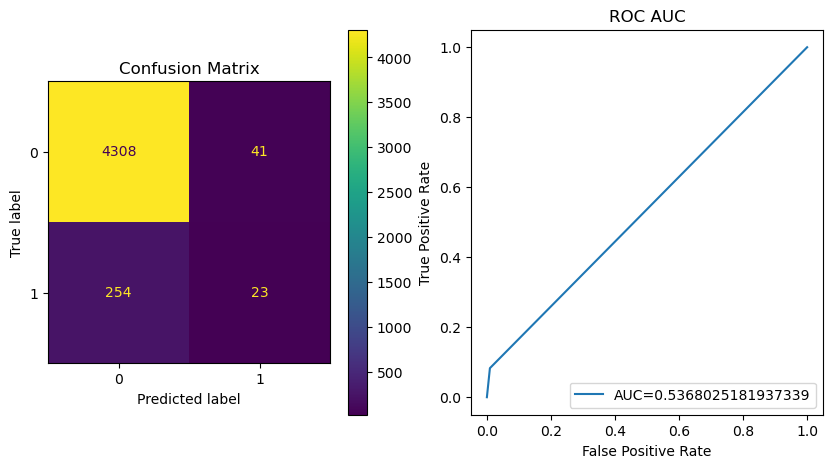

GridSearchCV(cv=RepeatedStratifiedKFold(n_repeats=10, n_splits=2, random_state=None),
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False,
                                     eval_metric='auc', feature_types=None,
                                     gamma=None, gpu_id=None, grow_policy=None,
                                     imp...
                                     max_cat_threshold=None,
                                     max_cat_to_onehot=None,
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=100, n_jobs=None,
                                     num_parallel_tree=None, predictor=None,
                                     random_state=None, ...),
             param_grid={'learning_rate': [0.1], 'max_depth': [5],
                         'min_child_weight': [4], 'n_estimators': [500]},
             scoring='precision')

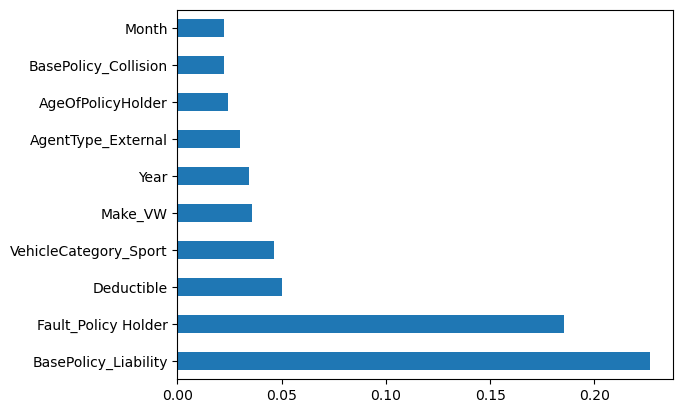

In [19]:
params = {
    'max_depth': [5], #[3,5,7],
    'min_child_weight': [4], #[1,3,5],
    'learning_rate': [0.1], #[0.1,0.01,0.001],
    'n_estimators': [500], #[100,500,1000]
         }

modeltype(X_train,X_test,XGBClassifier(use_label_encoder=False, objective= 'binary:logistic',eval_metric='auc'),params)

### Random forest

------------------------------------------------------------
Train Score: 0.9426
Test Score: 0.9397
------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.94      1.00      0.97      4349
           1       0.33      0.01      0.01       277

    accuracy                           0.94      4626
   macro avg       0.64      0.50      0.49      4626
weighted avg       0.90      0.94      0.91      4626

------------------------------------------------------------
Best parameters:  {'criterion': 'gini', 'min_samples_leaf': 3, 'min_samples_split': 3, 'n_estimators': 200}
------------------------------------------------------------
Best score:  0.56875


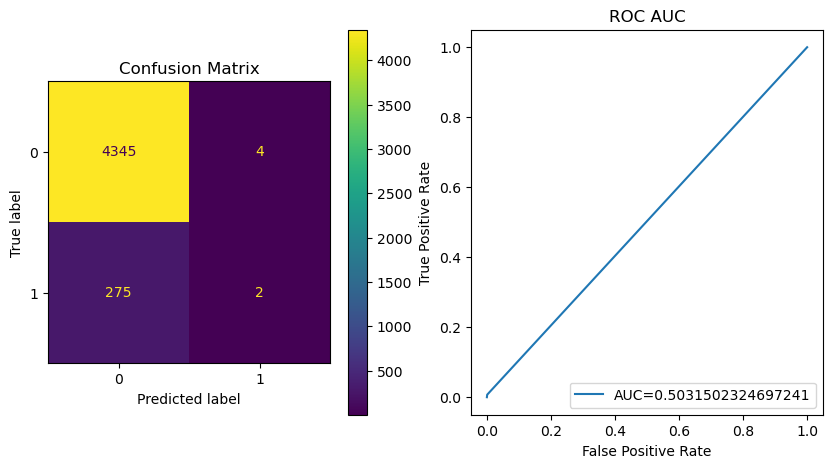

GridSearchCV(cv=RepeatedStratifiedKFold(n_repeats=10, n_splits=2, random_state=None),
             estimator=RandomForestClassifier(),
             param_grid={'criterion': ['gini'], 'min_samples_leaf': [3],
                         'min_samples_split': [3], 'n_estimators': [200]},
             scoring='precision')

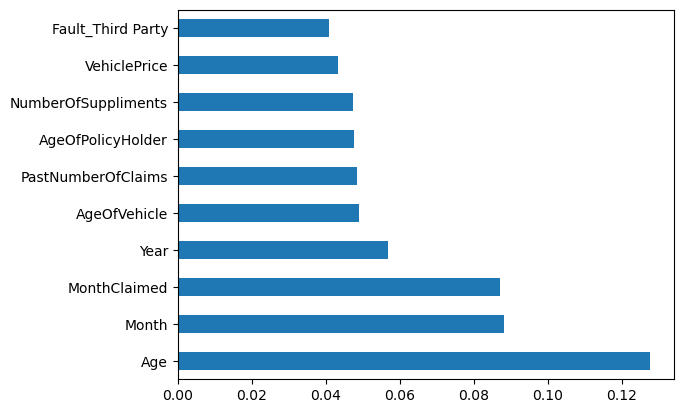

In [20]:
params = {
          'n_estimators':[200],
          'criterion':['gini'],
          'min_samples_split':[3],
          'min_samples_leaf':[3],
         }

modeltype(X_train,X_test,RandomForestClassifier(),params)

### Decision Tree 

------------------------------------------------------------
Train Score: 0.9668
Test Score: 0.9118
------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.95      0.96      0.95      4349
           1       0.17      0.12      0.14       277

    accuracy                           0.91      4626
   macro avg       0.56      0.54      0.55      4626
weighted avg       0.90      0.91      0.90      4626

------------------------------------------------------------
Best parameters:  {'criterion': 'log_loss', 'max_features': 'sqrt', 'min_samples_split': 4, 'splitter': 'random'}
------------------------------------------------------------
Best score:  0.18351016085555127


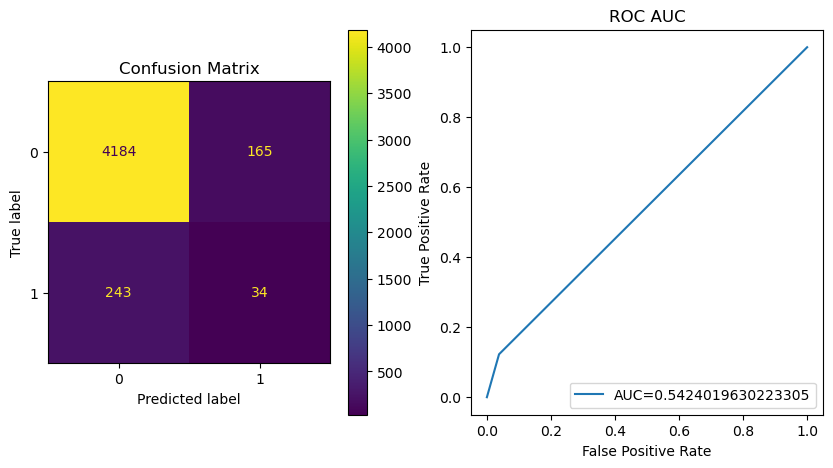

GridSearchCV(cv=RepeatedStratifiedKFold(n_repeats=10, n_splits=2, random_state=None),
             estimator=DecisionTreeClassifier(),
             param_grid={'criterion': ['log_loss'], 'max_features': ['sqrt'],
                         'min_samples_split': [4], 'splitter': ['random']},
             scoring='precision')

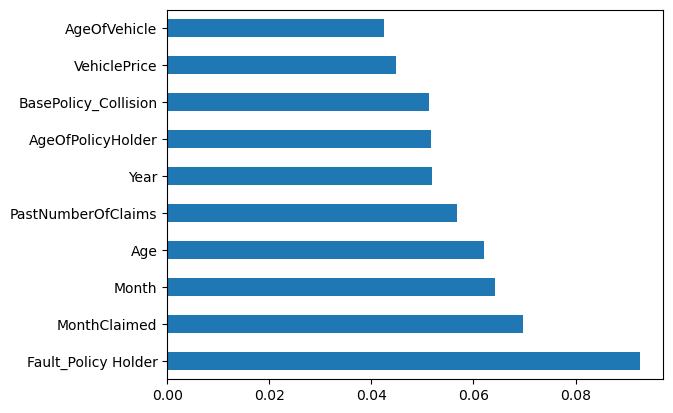

In [21]:
params = {
          'criterion':['log_loss'],    #['gini', 'entropy', 'log_loss'],
          'splitter':['random'],       #['best','random'],
          'min_samples_split':[4],     #[2,3,4,5],
          'max_features': ['sqrt']       #['','auto', 'sqrt', 'log2']
         }

modeltype(X_train,X_test,DecisionTreeClassifier(),params)

### Balanced Random Forest 

------------------------------------------------------------
Train Score: 0.6312
Test Score: 0.6256
------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.99      0.61      0.75      4349
           1       0.13      0.93      0.23       277

    accuracy                           0.63      4626
   macro avg       0.56      0.77      0.49      4626
weighted avg       0.94      0.63      0.72      4626

------------------------------------------------------------
Best parameters:  {'criterion': 'gini', 'max_features': 'log2', 'min_samples_leaf': 3, 'min_samples_split': 3, 'n_estimators': 300}
------------------------------------------------------------
Best score:  0.12770621618585193


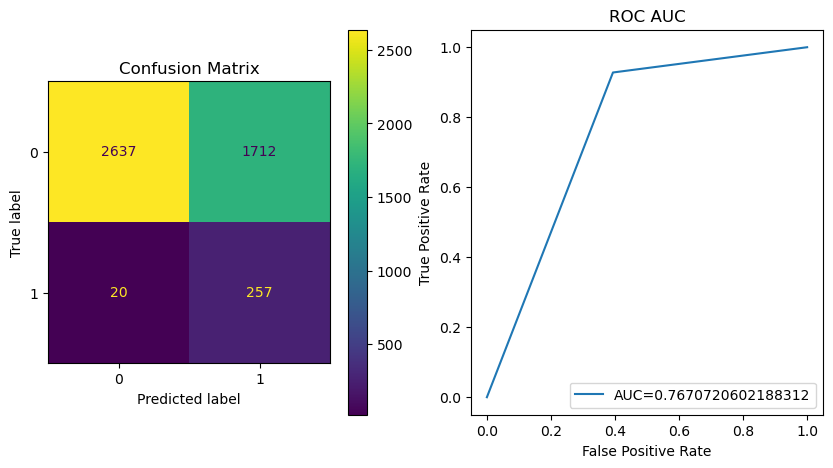

GridSearchCV(cv=RepeatedStratifiedKFold(n_repeats=10, n_splits=2, random_state=None),
             estimator=BalancedRandomForestClassifier(),
             param_grid={'criterion': ['gini'], 'max_features': ['log2'],
                         'min_samples_leaf': [3], 'min_samples_split': [3],
                         'n_estimators': [300]},
             scoring='precision')

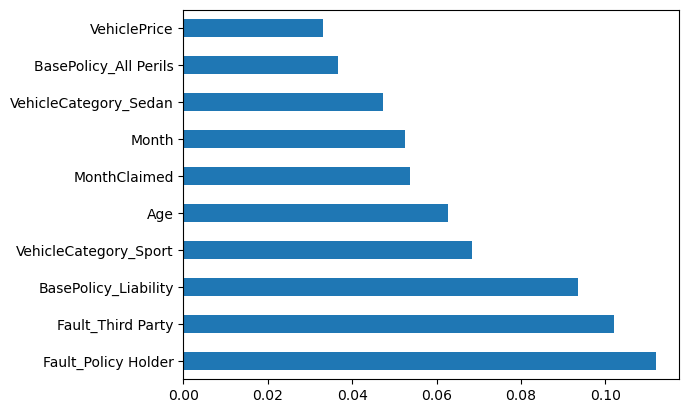

In [22]:
params = {
          'n_estimators':[300],
          'criterion':['gini'],
          'min_samples_split':[3],
          'min_samples_leaf':[3],
          'max_features':['log2']
         }

modeltype(X_train,X_test,BalancedRandomForestClassifier(),params)

### Ada Boosting

------------------------------------------------------------
Train Score: 0.9994
Test Score: 0.9358
------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.94      0.99      0.97      4349
           1       0.35      0.09      0.14       277

    accuracy                           0.94      4626
   macro avg       0.65      0.54      0.55      4626
weighted avg       0.91      0.94      0.92      4626

------------------------------------------------------------
Best parameters:  {'base_estimator__criterion': 'log_loss', 'base_estimator__min_samples_split': 3, 'base_estimator__splitter': 'random', 'learning_rate': 0.1, 'n_estimators': 50}
------------------------------------------------------------
Best score:  0.43088767094609925


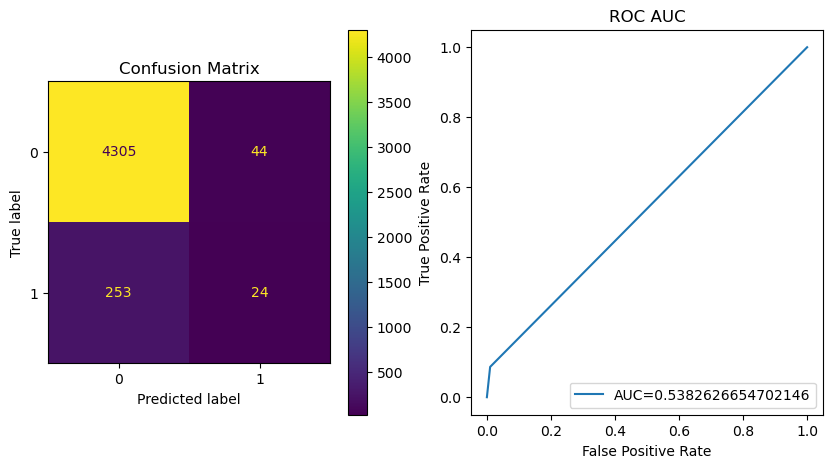

GridSearchCV(cv=RepeatedStratifiedKFold(n_repeats=10, n_splits=2, random_state=None),
             estimator=AdaBoostClassifier(base_estimator=DecisionTreeClassifier()),
             param_grid={'base_estimator__criterion': ['log_loss'],
                         'base_estimator__min_samples_split': [3],
                         'base_estimator__splitter': ['random'],
                         'learning_rate': [0.1], 'n_estimators': [50]},
             scoring='precision')

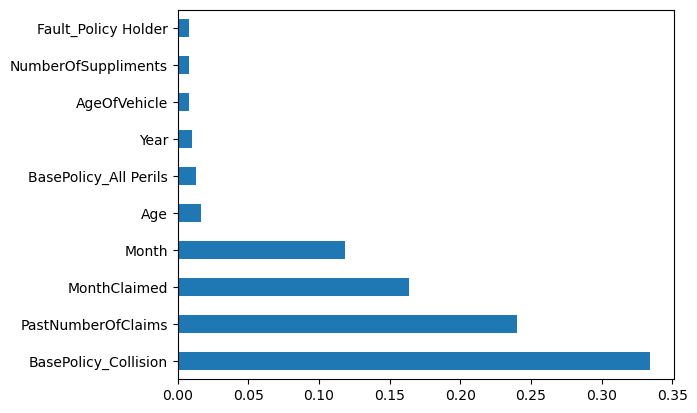

In [23]:
params = {
    'base_estimator__criterion': ['log_loss'],
    'base_estimator__splitter': ['random'], #['best', 'random'],
    'base_estimator__min_samples_split': [3], #[2, 3, 4, 5],
    'n_estimators': [50], #[50, 100, 200],
    'learning_rate': [0.1], #[0.1, 0.5, 1]
}

modeltype(X_train, X_test, AdaBoostClassifier(base_estimator=DecisionTreeClassifier()), params)

### Gradient Boosting

------------------------------------------------------------
Train Score: 0.9493
Test Score: 0.9423
------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.94      1.00      0.97      4349
           1       0.68      0.07      0.12       277

    accuracy                           0.94      4626
   macro avg       0.81      0.53      0.55      4626
weighted avg       0.93      0.94      0.92      4626

------------------------------------------------------------
Best parameters:  {'criterion': 'friedman_mse', 'learning_rate': 0.1, 'max_depth': 5, 'max_features': None, 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 100}
------------------------------------------------------------
Best score:  0.5030973048085307


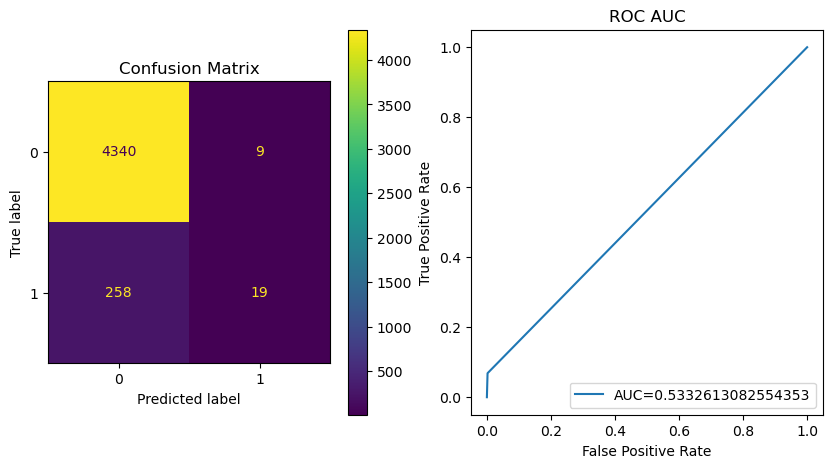

GridSearchCV(cv=RepeatedStratifiedKFold(n_repeats=10, n_splits=2, random_state=None),
             estimator=GradientBoostingClassifier(criterion=['friedman_mse'],
                                                  learning_rate=[0.1],
                                                  max_depth=[5],
                                                  max_features=[None],
                                                  min_samples_leaf=[4],
                                                  min_samples_split=[2],
                                                  n_estimators=[100]),
             param_grid={'criterion': ['friedman_mse'], 'learning_rate': [0.1],
                         'max_depth': [5], 'max_features': [None],
                         'min_samples_leaf': [4], 'min_samples_split': [2],
                         'n_estimators': [100]},
             scoring='precision')

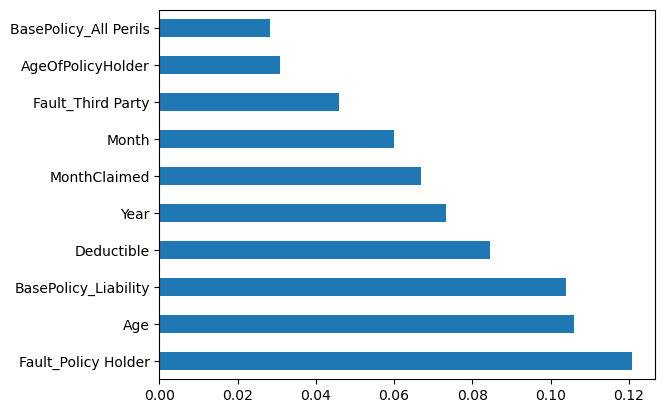

In [24]:
# Define the hyperparameters for the decision tree base estimator
dt_params = {
          'criterion':['log_loss'],#['gini', 'entropy', 'log_loss'],
          'splitter':['random'], #['best','random'],
          'min_samples_split':[4], #[2,3,4,5],
          'max_features':['sqrt'] #['','auto', 'sqrt', 'log2']
}

# Create an instance of DecisionTreeClassifier with the hyperparameters
dt = DecisionTreeClassifier(**dt_params)

# Define the hyperparameters for GradientBoostingClassifier
gb_params = {
    'learning_rate': [0.1], #[0.01, 0.1, 0.5],
    'n_estimators': [100],  #[50, 100, 200],
    'max_depth': [5],       #[3, 5, 7],
    'min_samples_split': [2],  #[2, 5, 10],
    'min_samples_leaf': [4],   #[1, 2, 4],
    'max_features': [None],    #['sqrt', 'log2', None],
    'criterion': ['friedman_mse']  #['friedman_mse', 'squared_error']
}

# Create an instance of GradientBoostingClassifier with the custom decision tree base estimator
gb = GradientBoostingClassifier(**gb_params)

# Pass the instance of GradientBoostingClassifier to the modeltype function
modeltype(X_train, X_test, gb, gb_params)



## Tuning the Target Weight & the Threshold

In [25]:
def find_best_tresh(pred_proba, y_test):
    df_res = pd.DataFrame({'prob':pred_proba})
    cut_off = [0.0,0.05, 0.1, 0.15 , 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95, 1]
    f1_result = []
    for i in cut_off:
        df_res['final_predicted'] = df_res['prob'].map( lambda x: 1 if x > i else 0)
        f1_result.append(roc_auc_score(y_test, df_res['final_predicted']))
    df_res2 = pd.DataFrame({'cut_off':cut_off, 'f1_score':f1_result})
    best_tresh = df_res2.sort_values('f1_score', ascending=False).head(1)['cut_off'].values[0]
    y_pred_thresh = (y_pred >= best_tresh).astype('float')
    print('Best Threshold :', best_tresh)
    metric_result(y_test, y_pred_thresh)

### XGBoost

------------------------------------------------------------
Train Score: 0.9097
Test Score: 0.8472
------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.97      0.86      0.91      4349
           1       0.21      0.58      0.31       277

    accuracy                           0.85      4626
   macro avg       0.59      0.72      0.61      4626
weighted avg       0.92      0.85      0.88      4626

------------------------------------------------------------
Best parameters:  {'learning_rate': 0.1, 'max_depth': 5, 'min_child_weight': 4, 'n_estimators': 500, 'scale_pos_weight': 25}
------------------------------------------------------------
Best score:  0.2235241866431124


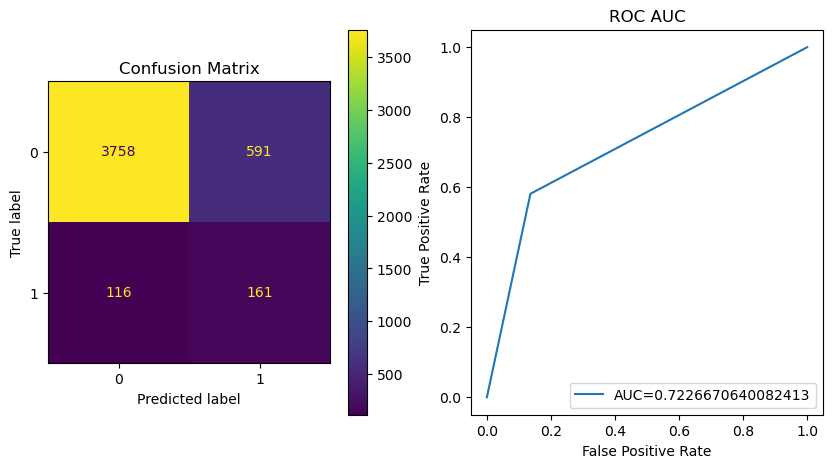

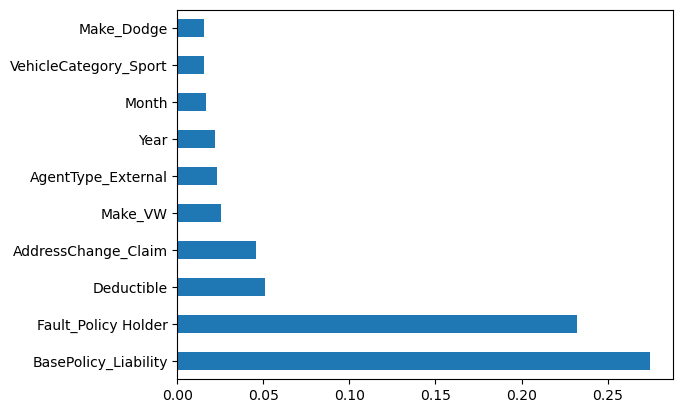

In [26]:
params = {
    'max_depth': [5], #[3,5,7],
    'min_child_weight': [4], #[1,3,5],
    'learning_rate': [0.1], #[0.1,0.01,0.001],
    'n_estimators': [500], #[100,500,1000]
    'scale_pos_weight': [25]
         }

xgbc = XGBClassifier(use_label_encoder=False, objective= 'binary:logistic',eval_metric='auc')


xgb_model = modeltype(X_train,X_test,xgbc,params)

Best Threshold : 0.1
F1 Score :  0.2663013698630137
Recall Score :  0.8772563176895307
Precision Score :  0.1569767441860465


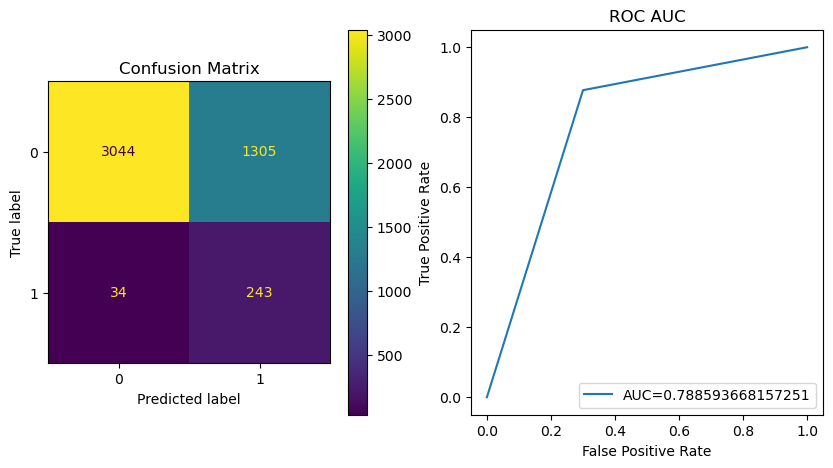

In [27]:
y_pred = xgb_model.predict_proba(X_test)[:, 1].tolist()
find_best_tresh(y_pred, y_test)

### Random forest

------------------------------------------------------------
Train Score: 0.9712
Test Score: 0.939
------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.94      0.99      0.97      4349
           1       0.44      0.06      0.11       277

    accuracy                           0.94      4626
   macro avg       0.69      0.53      0.54      4626
weighted avg       0.91      0.94      0.92      4626

------------------------------------------------------------
Best parameters:  {'class_weight': {0: 0.21391959798994975, 1: 0.7860804020100502}, 'criterion': 'gini', 'min_samples_leaf': 3, 'min_samples_split': 3, 'n_estimators': 200}
------------------------------------------------------------
Best score:  0.44753275687345334


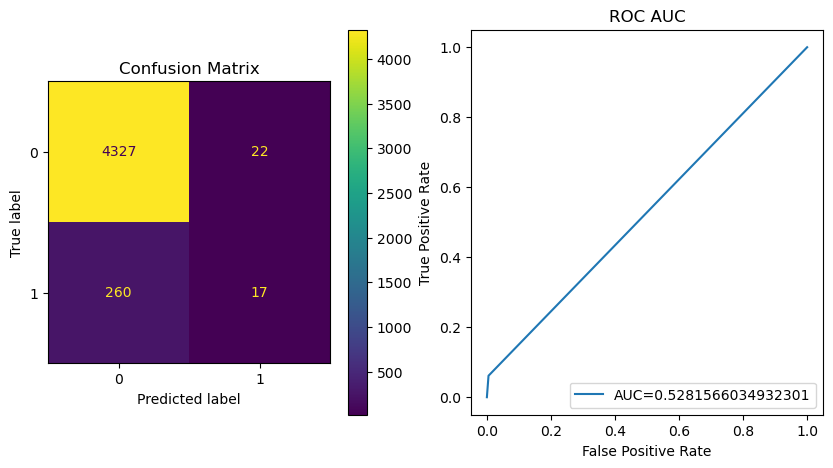

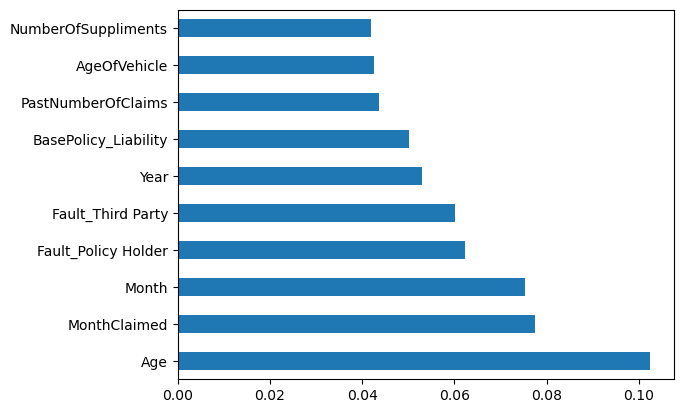

In [28]:
params = {
          'n_estimators':[200],
          'criterion':['gini'],
          'min_samples_split':[3],
          'min_samples_leaf':[3],
          'class_weight': [{0: 0.21391959798994975, 1: 0.7860804020100502}]
         }

rf_model = modeltype(X_train,X_test,RandomForestClassifier(),params)

Best Threshold : 0.15
F1 Score :  0.250926416093171
Recall Score :  0.855595667870036
Precision Score :  0.14702233250620347


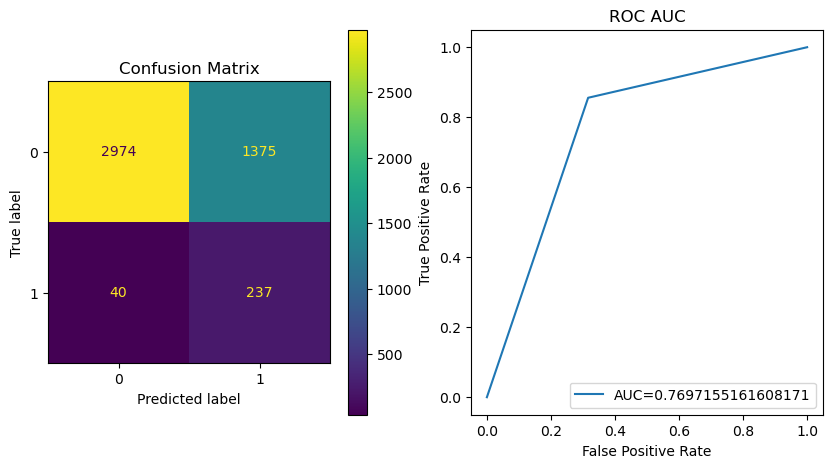

In [29]:
y_pred = rf_model.predict_proba(X_test)[:, 1].tolist()
find_best_tresh(y_pred, y_test)

### Decision Tree 

------------------------------------------------------------
Train Score: 0.9546
Test Score: 0.8772
------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.95      0.92      0.93      4349
           1       0.17      0.26      0.20       277

    accuracy                           0.88      4626
   macro avg       0.56      0.59      0.57      4626
weighted avg       0.90      0.88      0.89      4626

------------------------------------------------------------
Best parameters:  {'class_weight': {0: 0.20894472361809047, 1: 0.7910552763819095}, 'criterion': 'log_loss', 'max_features': 'sqrt', 'min_samples_split': 4, 'splitter': 'random'}
------------------------------------------------------------
Best score:  0.15811240753252204


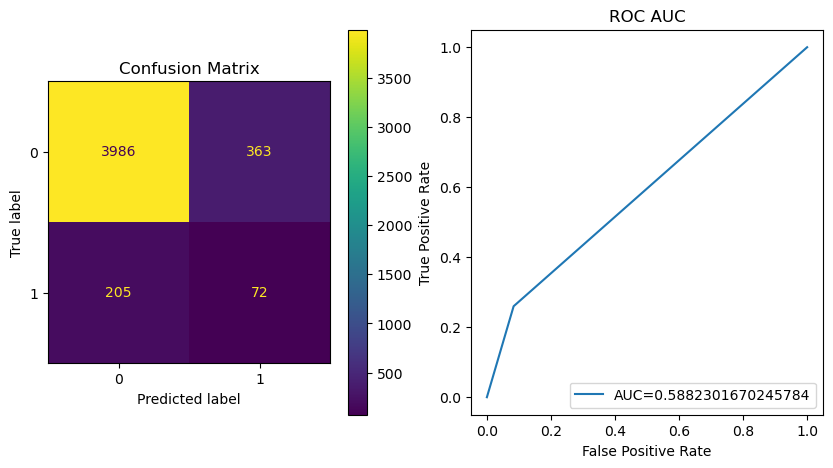

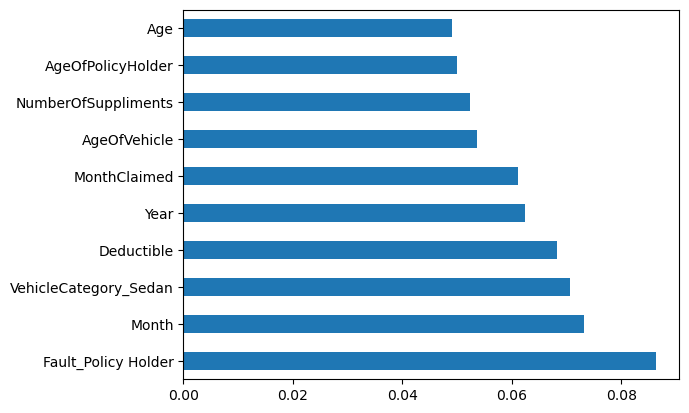

In [30]:
params = {
          'criterion':['log_loss'],#['gini', 'entropy', 'log_loss'],
          'splitter':['random'], #['best','random'],
          'min_samples_split':[4], #[2,3,4,5],
          'max_features':['sqrt'],   #['','auto', 'sqrt', 'log2']
          'class_weight': [{0: 0.20894472361809047, 1: 0.7910552763819095}]
         }

dt_model = modeltype(X_train,X_test,DecisionTreeClassifier(),params)

Best Threshold : 0.0
F1 Score :  0.1129920456863145
Recall Score :  1.0
Precision Score :  0.05987894509295288


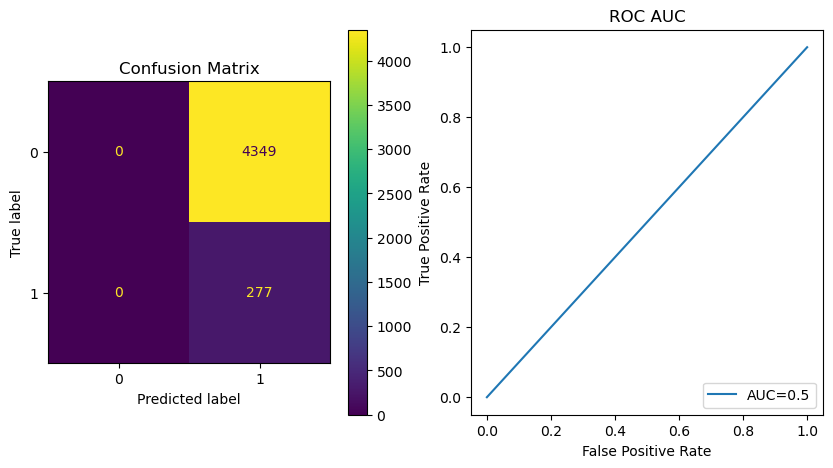

In [31]:
y_pred = dt_model.predict_proba(X_test)[:, 1].tolist()
find_best_tresh(y_pred, y_test)

### Balanced Random Forest 

------------------------------------------------------------
Train Score: 0.5991
Test Score: 0.601
------------------------------------------------------------
              precision    recall  f1-score   support

           0       1.00      0.58      0.73      4349
           1       0.13      0.96      0.22       277

    accuracy                           0.60      4626
   macro avg       0.56      0.77      0.48      4626
weighted avg       0.94      0.60      0.70      4626

------------------------------------------------------------
Best parameters:  {'class_weight': {0: 0.21391959798994975, 1: 0.7860804020100502}, 'criterion': 'gini', 'max_features': 'log2', 'min_samples_leaf': 3, 'min_samples_split': 3, 'n_estimators': 300}
------------------------------------------------------------
Best score:  0.12342968240289143


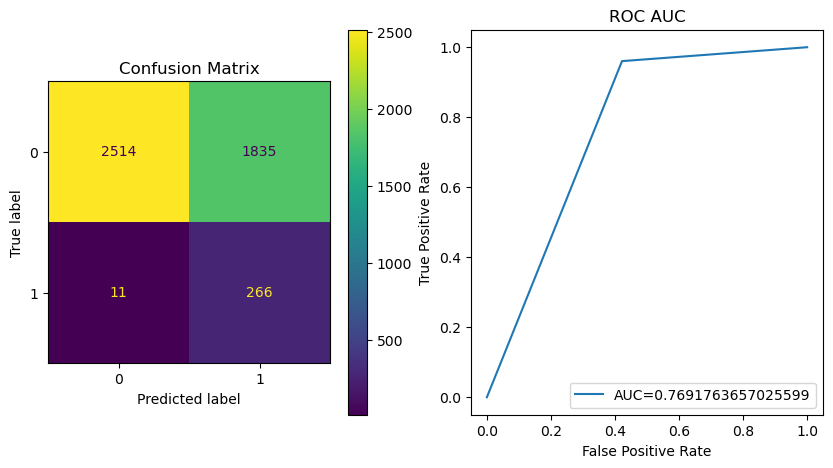

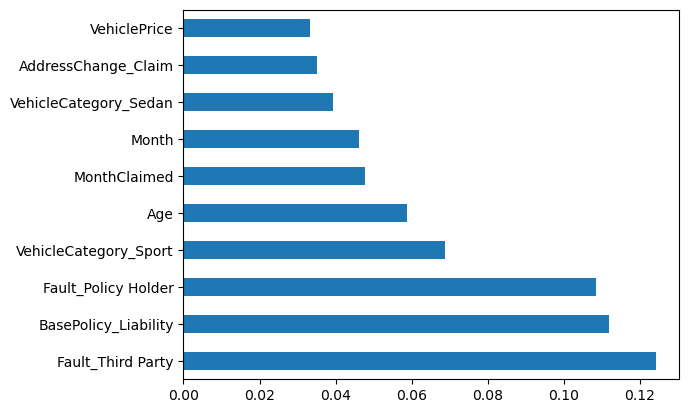

In [32]:
params = {
          'n_estimators':[300],
          'criterion':['gini'],
          'min_samples_split':[3],
          'min_samples_leaf':[3],
          'max_features':['log2'],
          'class_weight': [{0: 0.21391959798994975, 1: 0.7860804020100502}]
         }

brf_model = modeltype(X_train,X_test,BalancedRandomForestClassifier(),params)

Best Threshold : 0.55
F1 Score :  0.22561492790500426
Recall Score :  0.9602888086642599
Precision Score :  0.12782316194137433


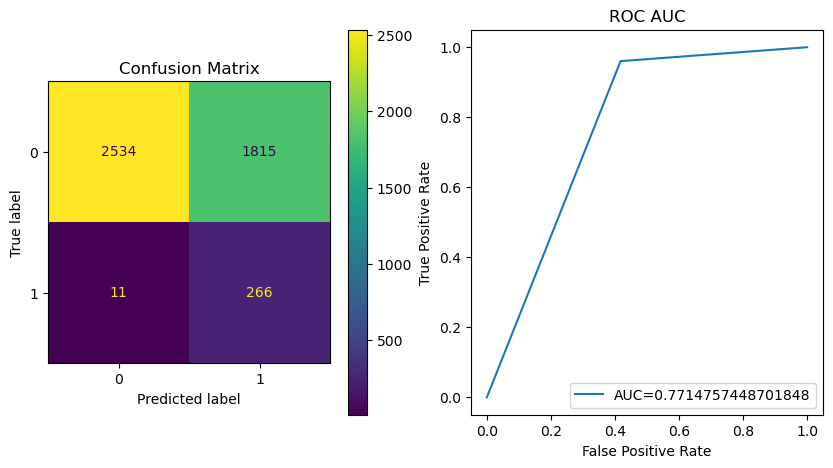

In [33]:
y_pred = brf_model.predict_proba(X_test)[:, 1].tolist()
find_best_tresh(y_pred, y_test)

### Gradient Boosting

------------------------------------------------------------
Train Score: 0.9493
Test Score: 0.9423
------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.94      1.00      0.97      4349
           1       0.68      0.07      0.12       277

    accuracy                           0.94      4626
   macro avg       0.81      0.53      0.55      4626
weighted avg       0.93      0.94      0.92      4626

------------------------------------------------------------
Best parameters:  {'criterion': 'friedman_mse', 'learning_rate': 0.1, 'max_depth': 5, 'max_features': None, 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 100}
------------------------------------------------------------
Best score:  0.5217542135640463


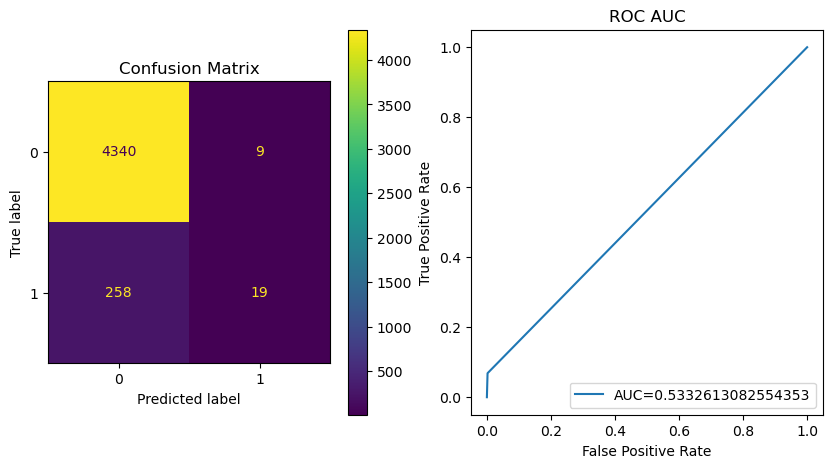

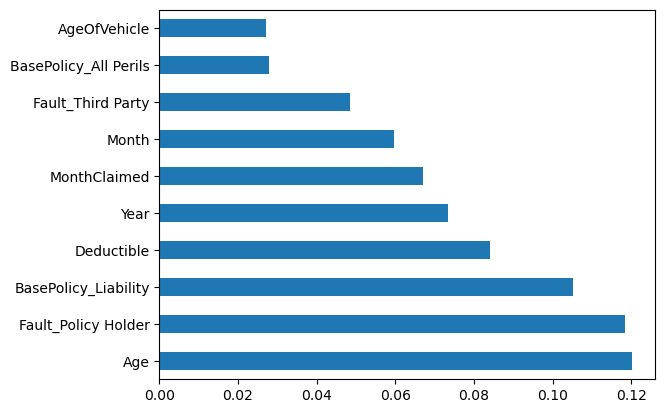

In [34]:
# Define the hyperparameters for the decision tree base estimator
dt_params = {
          'criterion':['log_loss'],#['gini', 'entropy', 'log_loss'],
          'splitter':['random'], #['best','random'],
          'min_samples_split':[4], #[2,3,4,5],
          'max_features':['sqrt'], #['','auto', 'sqrt', 'log2']
          'class_weight': [{0: 0.20894472361809047, 1: 0.7910552763819095}]
}

# Create an instance of DecisionTreeClassifier with the hyperparameters
dt = DecisionTreeClassifier(**dt_params)

# Define the hyperparameters for GradientBoostingClassifier
gb_params = {
    'learning_rate': [0.1], #[0.01, 0.1, 0.5],
    'n_estimators': [100],  #[50, 100, 200],
    'max_depth': [5],       #[3, 5, 7],
    'min_samples_split': [2],  #[2, 5, 10],
    'min_samples_leaf': [4],   #[1, 2, 4],
    'max_features': [None],    #['sqrt', 'log2', None],
    'criterion': ['friedman_mse'],  #['friedman_mse', 'squared_error']
    
}

# Create an instance of GradientBoostingClassifier with the custom decision tree base estimator
gb = GradientBoostingClassifier(**gb_params)

# Pass the instance of GradientBoostingClassifier to the modeltype function
gb_model = modeltype(X_train, X_test, gb, gb_params)


Best Threshold : 0.05
F1 Score :  0.24304538799414344
Recall Score :  0.8989169675090253
Precision Score :  0.14051918735891647


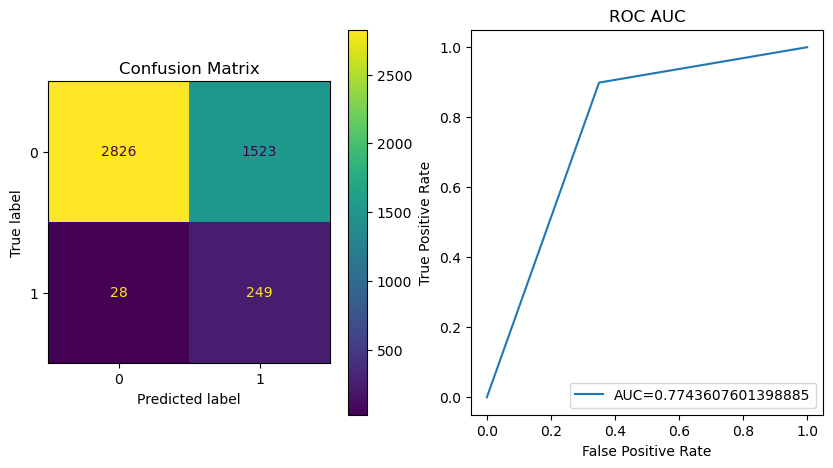

In [35]:
y_pred = gb_model.predict_proba(X_test)[:, 1].tolist()
find_best_tresh(y_pred, y_test)